## Reconstruction parcimonieuse

On s'intéresse au problème

$$\hspace{5cm} (\mathcal{P})\quad \min_{x\in \mathbb{R}^n}f(x) = \frac{1}{2}\Vert H x-y \Vert_W^2+\lambda \Vert x \Vert_1 $$

avec $y\in \mathbb{R}^m$ une observation du signal à reconstruire, $H\in \mathcal{M}_{m,n}(\mathbb{R})$, $W\in \mathcal{M}_{m}(\mathbb{R})$ symétrique définie positive. La matrice $W$ introduit une pondération sur les composantes du résidu.

  Activating project at `~/Cours/S7/Optimisation/Convexe/TP`


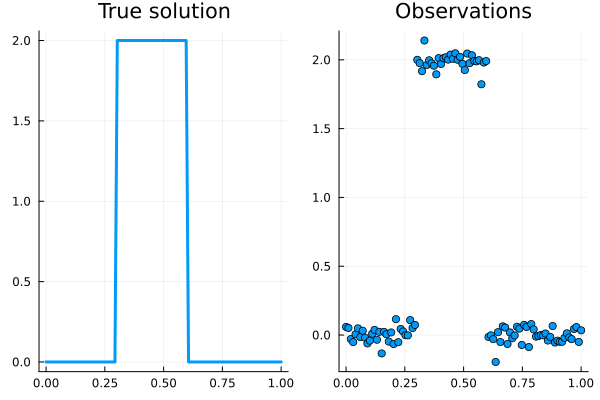

In [1]:
using Pkg
Pkg.activate(".")

using Plots
using LinearAlgebra

# Construction du problème #
############################

# solution à reconstruire 
##########################
dx=0.01;

n=Int(1/dx);#+1;
px=LinRange(0.,1.,n);
xt=zeros(n,1);

for i = 1:n
    if (px[i] > 0.3 && px[i]< 0.6)
        xt[i] = 2;         
    end
end


#observations
#############
nobs=1;
m=Int(floor(n/nobs));
var_obs=0.05;
sigmaW=ones(m,1)+2.0*rand(Float64,(m,1));

H=zeros(m,n);
py=zeros(m,1);
W=zeros(m,m);
for i=1:m
   H[i,(i-1)*nobs+1]=1;
   py[i]=px[(i-1)*nobs+1]; 
   W[i,i]=sigmaW[i];
end    
y=H*xt+var_obs*randn(Float64,(m,1));


p1=plot(px,xt,title="True solution",label=["xt"],lw=3);
p2=scatter(py,y,title="Observations",lw=3);
plot(p1,p2,layout=(1,2),legend=false)

**Question 1 :** Justifier la convexité de la fonctionnelle et donner un sous-gradient.

On a : $f = \frac{1}{2}\Vert H x-y \Vert_W^2+\lambda \Vert x \Vert_1 $. Donc $f$ est convexe par somme de fonctions convexes.

De plus, $\partial f(x) = H^T W (Hx - y) + \lambda \cdot \text{sign}(x)$

**Question 2 :** Proposer le calcul de l'évaluation de f et d'un sous-gradient de f

In [2]:
# Fonction évaluant f en x
function evalf(x, y, H, W, lambda)
    # Terme quadratique
    quad_term = 0.5 * norm(W * (H * x - y))^2
    
    # Terme de régularisation L1
    l1_term = lambda * norm(x, 1)
    
    return quad_term + l1_term
end

# Fonction évaluant un sous-gradient de f en x
function subgradf(x, y, H, W, lambda)
    # Terme quadratique
    quad_grad = H' * W * (H * x - y)
    
    # Terme de régularisation L1
    l1_grad = lambda * sign.(x)
    
    return quad_grad + l1_grad
end;


**Question 3 :** Résoudre le problème en utilisant un algorithme de sous-gradient. Vous implanterez les trois stratégies de pas vues en cours. Vous afficherez les courbes de convergence de $f_{best}^k$.

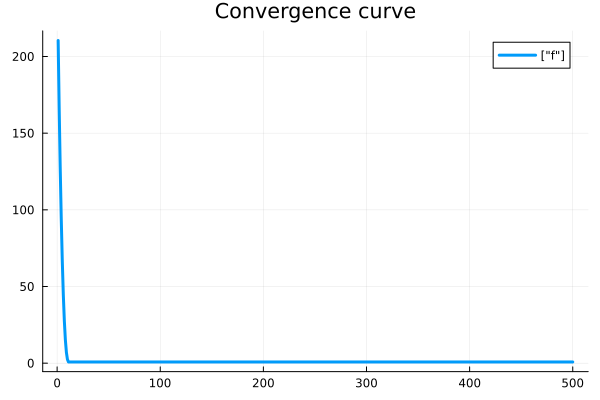

In [3]:
# Algorithme de sous-gradient
function sous_gradient_algorithm(y, H, W, lambda, choix_pas, itermax)
    n = size(H, 2)
    x = zeros(n)
    xbest = x
    fbest =1000000; # $f_{best}^0$
    histo =[];# Suite des itérés f_{best}^k

    for i in 1:itermax
        # Calculer le sous-gradient
        grad_f = subgradf(x, y, H, W, lambda)

        # Choix du pas
        if choix_pas == 1
            alpha_k = 0.1
        elseif choix_pas == 2
            alpha_k = 1 / sqrt(i)
        elseif choix_pas == 3
            alpha_k = 1 / norm(grad_f, 2)
        end

        # Mettez à jour la solution en utilisant le sous-gradient
        x = x - alpha_k * grad_f

        # Evaluation de la fonction objectif
        fx = evalf(x, y, H, W, lambda);

        # Mise à jour de la meilleure solution
        if fx < fbest
            fbest = fx;
            xbest = x;
        end
        
        # Stockage
        append!(histo, fbest)
    end

    return xbest, fbest, histo
end

# Paramètres
lambda=1e-2;
pas=3
itermax=500;

# Résoudre le problème
xbest, fbest, histo = sous_gradient_algorithm(y, H, W, lambda, pas, itermax)

# Afficher les courbes de convergence
iter=1:itermax;
plot(iter,histo,title="Convergence curve",label=["f"],lw=3)

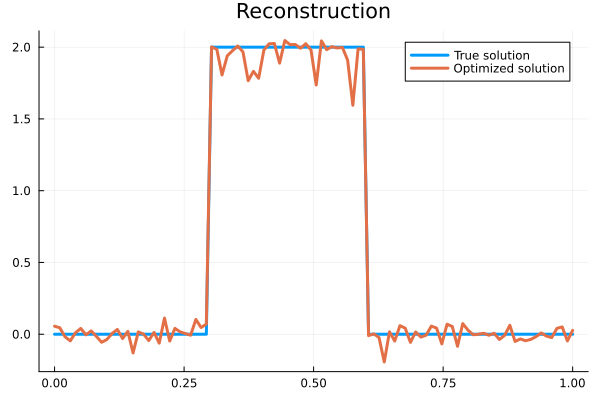

In [4]:
x=[xt,xbest];

plot(px,x,title="Reconstruction",label=["True solution" "Optimized solution"],lw=3)

**Question 4 :** Quelle influence a le paramètre $\lambda$ sur la convergence de l'algorithme et la qualité de la solution optimisée ?

In [5]:
# Influence de lambda sur la solution
lambda_list = [1e-2, 1e-1, 1, 10, 100]
for lambda in lambda_list
    xbest, fbest, histo = sous_gradient_algorithm(y, H, W, lambda, pas, itermax)
    x=[xt,xbest];
    plot(px,x,title="Reconstruction",label=["True solution" "Optimized solution"],lw=3)
end

**Question 5 :** On pose $h(x)=\lambda \Vert x\Vert_1$ et $g(x)=\frac{1}{2}\Vert Hx-y\Vert_W^2$. Donner une expression analytique de la fonction proximale de h et implanter cette fonction. Implanter la fonction $g$ ainsi que son gradient.


In [6]:
# Evaluation de prox_h
function proxh(x, lambda)
    return sign.(x) .* max.(0, abs.(x) .- lambda)
end

# Evaluation de g
function evalg(x, y, H, W)
    return 0.5 * norm(W * (H * x - y))^2
end

# Evaluation du gradient de g
function gradg(x, y, H, W)
    return H' * W * (H * x - y)
end;

**Question 6 :** Résoudre le problème par la méthode du gradient proximal avec recherche linéaire pour le pas. Vous implanterez en prémabule la fonction de recherche linéaire.

In [7]:
# Fonction de recherche linéaire
function line_search(x, y, H, W, lambda, alpha0, beta)
    grad_f = subgradf(x, y, H, W, lambda)
    d = -grad_f
    
    alpha = alpha0
    c = evalf(x + alpha * d, y, H, W, lambda) - evalf(x, y, H, W, lambda) - beta * alpha * dot(grad_f, d)
    
    while c > 0
        alpha = alpha / 2
        c = evalf(x + alpha * d, y, H, W, lambda) - evalf(x, y, H, W, lambda) - beta * alpha * dot(grad_f, d)
    end
    
    return alpha
end;

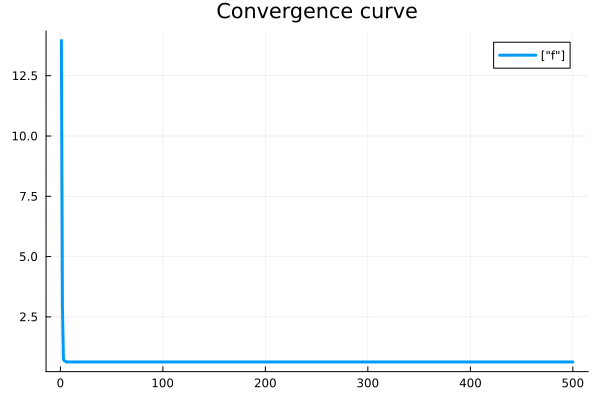

In [21]:
# Algorithme de sous-gradient
function sous_gradient_algorithm_linesearch(y, H, W, lambda, choix_pas, itermax)
    n = size(H, 2)
    x = zeros(n)
    xbest = x
    fbest =1000000; # $f_{best}^0$
    histo =[];# Suite des itérés f_{best}^k

    for i in 1:itermax
        # Calcul du sous-gradient
        grad_f = subgradf(x, y, H, W, lambda)
        
        # Recherche linéaire pour trouver le pas optimal
        alpha_k = line_search(x, y, H, W, lambda, lambda0, beta)
        
        # Mise à jour de la solution
        x = proxh(x - alpha_k * grad_f, lambda)
        
        # Evaluation de la fonction objectif
        fx = evalf(x, y, H, W, lambda)
        
        # Mise à jour de la meilleure solution
        if fx < fbest
            fbest = fx
            xbest = x
        end
        
        # Stockage
        append!( histo, fbest)
        end

    return xbest, fbest, histo
end

# Paramètres
lambda=1e-2;
lambda0=100;
itermax=500;

# Résoudre le problème
xbest, fbest, histo = sous_gradient_algorithm_linesearch(y, H, W, lambda, pas, itermax)

# Afficher les courbes de convergence
iter=1:itermax;
plot(iter,histo,title="Convergence curve",label=["f"],lw=3)

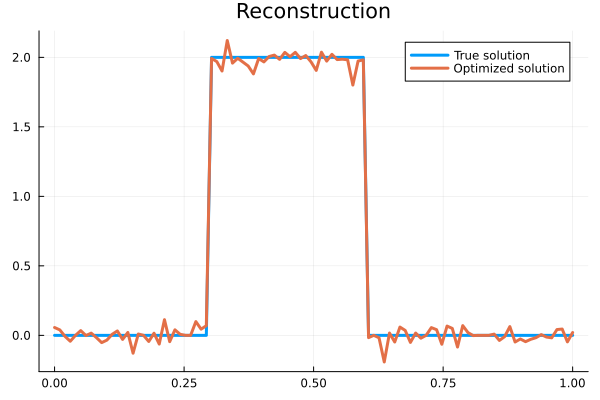

In [22]:
x=[xt,xbest];

plot(px,x,title="Reconstruction",label=["True solution" "Optimized solution"],lw=3)

**Question 7 :** Evaluez la sensisibilité de l'algorithme aux différents paramètres : $\lambda_0$, $\beta$, itermax.  

In [26]:
# Fonction d'évaluation de la sensibilité
function evaluate_sensitivity(lambda0, beta, itermax)
    # Résoudre le problème
    xbest, fbest, histo = sous_gradient_algorithm_linesearch(y, H, W, lambda0, beta, itermax)
    
    # Afficher les courbes de convergence
    iter=1:itermax;
    p1 = plot(iter,histo,title="Convergence curve",label=["f"],lw=3)

    x=[xt,xbest];

    p2 = plot(px,x,title="Reconstruction",label=["True solution" "Optimized solution"],lw=3)
    return p1, p2
end

# Exemple d'évaluation de sensibilité
lambda0_values = [1, 10, 100]
beta_values = [0.1, 0.5, 0.9]
itermax_values = [100, 500, 1000]

for λ₀ in lambda0_values
    for β in beta_values
        for itmax in itermax_values
            println("Sensibilité pour λ₀=$λ₀, β=$β, itermax=$itmax")
            p1, p2 = evaluate_sensitivity(λ₀, β, itmax)
            println("----------------------------------------------")
        end
    end
end


Sensibilité pour λ₀=1, β=0.1, itermax=100


----------------------------------------------
Sensibilité pour λ₀=1, β=0.1, itermax=500


----------------------------------------------
Sensibilité pour λ₀=1, β=0.1, itermax=1000


----------------------------------------------
Sensibilité pour λ₀=1, β=0.5, itermax=100
----------------------------------------------
Sensibilité pour λ₀=1, β=0.5, itermax=500


----------------------------------------------
Sensibilité pour λ₀=1, β=0.5, itermax=1000


----------------------------------------------
Sensibilité pour λ₀=1, β=0.9, itermax=100
----------------------------------------------
Sensibilité pour λ₀=1, β=0.9, itermax=500


----------------------------------------------
Sensibilité pour λ₀=1, β=0.9, itermax=1000


----------------------------------------------
Sensibilité pour λ₀=10, β=0.1, itermax=100


----------------------------------------------
Sensibilité pour λ₀=10, β=0.1, itermax=500


InterruptException: InterruptException: